In [186]:
import magnonRPA as rpa
import numpy as np

from matplotlib import pyplot as plt 
from matplotlib import colors as mclr
from matplotlib import colormaps as cmaps

### Plotting settings 
#plt.rc('figure', dpi=100)
#plt.rc('figure',figsize=(4,1.7))
plt.rc('font', family = 'Times New Roman')
plt.rc('font', size = 14)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=18)
plt.rc('lines', linewidth=2.5)

saveFigs = False ### Option to save figures or not 

figDirectory = "../figures/" ### Figures are stored in this folder
dataDirectory = "../data/" ### Data is loaded from and stored to this folder


## Set parameters

In [263]:
T = 0.11*rpa.t ##$ temperature
U = 7.5*rpa.t ### Hubbard U (used to compute J)
J = 4.*rpa.t**2/U ### Superexchange J
mu = -3*rpa.t ### Chemical potential (controls doping)

## Load in spectral functions and make a plot of it

In [264]:
### Location of hole spectral functions
holesDirectory = dataDirectory+"hole_spectra/03252025/" 
holesFile = "Hole_Spectral_functionJz0.05_alfa0.999_Nx20_Ny20" 

### Load in spectral function
kxs,kys,ws,A = rpa.load_hole_spectrum(holesDirectory+holesFile)

### Useful to make vectorized grids and keep track of sizes of arrays
kxvs,kyvs,wvs = np.meshgrid(kxs,kys,ws)
Nkx = len(kxs)
Nky = len(kys)
Nw = len(ws)

### Compute doping
delta = rpa.calc_density(kxs,kys,ws,A,mu,T)
print("Hole doping: {d:0.1%}".format(d=delta))

Hole doping: 3.8%


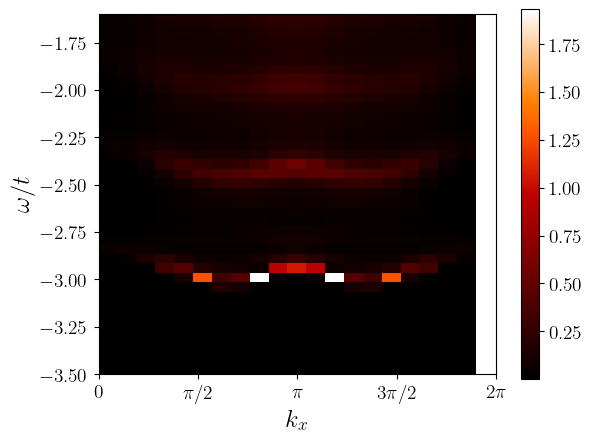

In [265]:
### Plot spectral function for a cut
plt.imshow(np.transpose(A[:,0,:]),extent=[kxs[0],kxs[-1],ws[0],ws[-1]],origin='lower',cmap='gist_heat',aspect=3.)
plt.colorbar()
plt.ylim(-3.5*rpa.t,-1.6*rpa.t)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$\omega/t$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.show()

## Now we compute the RPA kernel and magnon propagator

In [266]:
### Calculate RPA spectra from hole spectra 
ImPi = rpa.calc_ImPi(kxs,kys,ws,A,mu,T)
Pi = rpa.Kramers_Kronig(ws,ImPi)

In [267]:
### Magnon propagator
magnon_kernel = rpa.RPA_kernel(kxs,kys,ws,Pi,J)
magnon_propagator = np.zeros_like(magnon_kernel)
spectra = np.zeros((Nkx,Nky,Nw))

for i in range(len(kxs)):
    for j in range(len(kys)):
        for k in range(len(ws)):
            magnon_propagator[:,:,i,j,k] = np.linalg.inv(magnon_kernel[:,:,i,j,k])
            spectra[i,j,k] = ws[k]*np.imag( np.linalg.det(magnon_propagator[:,:,i,j,k]) )/np.pi


## Plotting and various diagonostics

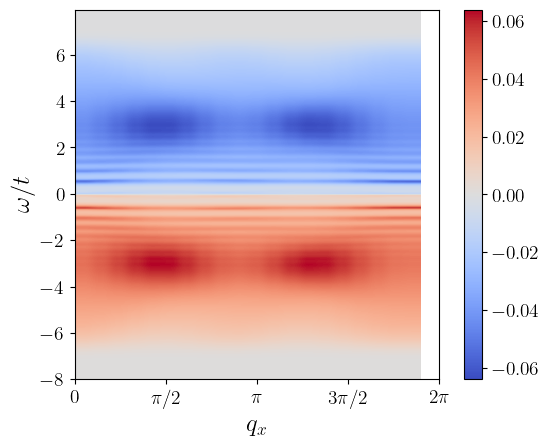

In [268]:
### Frequency dependence of Pi for kx cut 
plt.imshow(np.transpose(ImPi[:,0,:]),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=0.4,cmap='coolwarm')
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.ylabel(r'$\omega/t$')
plt.colorbar()
if saveFigs: plt.savefig(figDirectory+"/ImPi_w_qx.pdf",bbox_inches='tight')
plt.show()

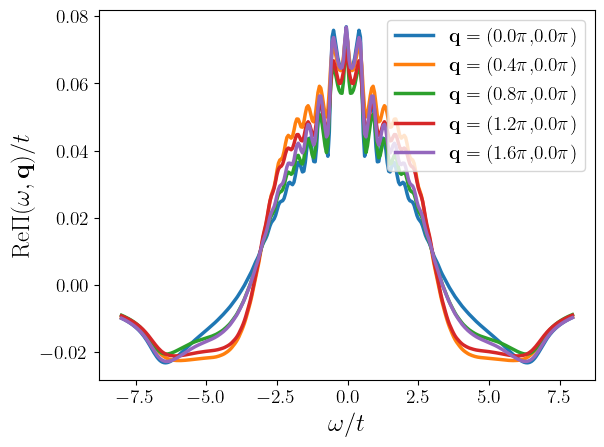

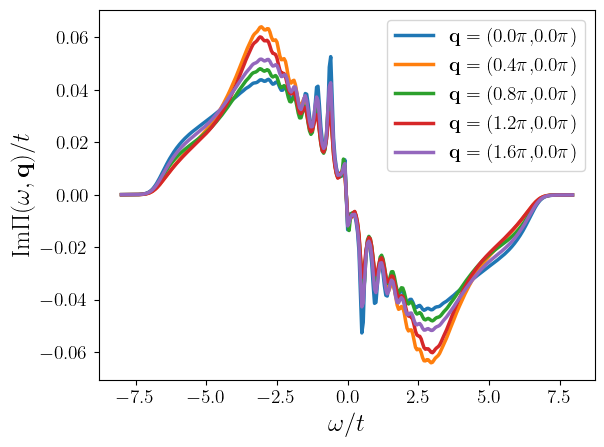

In [269]:
### Frequency-momentum cuts of RPA function
indices = [ [0,0],[4,0],[8,0],[12,0],[16,0]]
#clrs = cmaps['Reds'](np.linspace(0.4,1.,len(indices)))
#clrs = ['red','green','blue','purple']
label_strings = [ r'$\mathbf{q}=($'+"{qx:0.1f}".format(qx=kxs[i[0]]/np.pi) + r'$\pi,$' + "{qy:0.1f}".format(qy=kys[i[1]]/np.pi) + r'$\pi)$'  for i in indices]

### Frequency cuts of polarizations of magnons
if True:
    for j in range(len(indices)):
        i = indices[j]
        plt.plot(ws/rpa.t,np.real(Pi[i[0],i[1],:])/rpa.t,label=label_strings[j])
    
    plt.xlabel(r'$\omega/t$')
    plt.ylabel(r'Re$\Pi(\omega,\mathbf{q})/t$')
    plt.legend()
    if saveFigs: plt.savefig(figDirectory+"/RePi.pdf",bbox_inches='tight')
    plt.show()

if True:
    for j in range(len(indices)):
        i = indices[j]
        plt.plot(ws/rpa.t,np.imag(Pi[i[0],i[1],:])/rpa.t,label=label_strings[j])

    plt.xlabel(r'$\omega/t$')
    plt.ylabel(r'Im$\Pi(\omega,\mathbf{q})/t$')
    plt.legend()
    if saveFigs: plt.savefig(figDirectory+"/ImPi.pdf",bbox_inches='tight')
    plt.show()


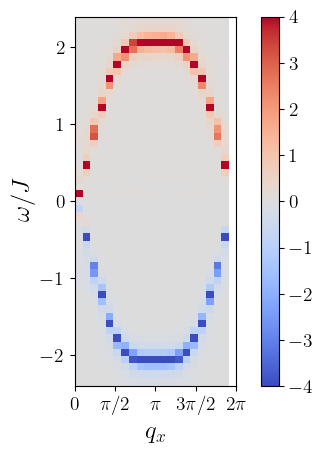

In [270]:
normed = mclr.Normalize(-4.,4.)
plt.imshow(np.transpose(spectra[:,0,:]),origin='lower',extent=[kxs[0],kxs[-1],ws[0]/J,ws[-1]/J],cmap='coolwarm',aspect=3,norm=normed)
plt.ylabel(r'$\omega/J$')
plt.ylim(-4.5*J,4.5*J)
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.colorbar()
#if saveFigs: plt.savefig(figDirectory+"/Magnon_spectrum.pdf",bbox_inches='tight')
plt.show()

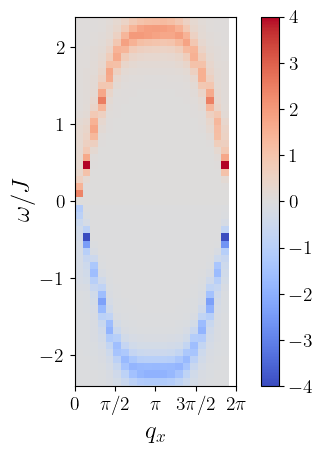

In [262]:
normed = mclr.Normalize(-4.,4.)
plt.imshow(np.transpose(spectra[:,0,:]),origin='lower',extent=[kxs[0],kxs[-1],ws[0]/J,ws[-1]/J],cmap='coolwarm',aspect=3,norm=normed)
plt.ylabel(r'$\omega/J$')
plt.ylim(-4.5*J,4.5*J)
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.colorbar()
#if saveFigs: plt.savefig(figDirectory+"/Magnon_spectrum.pdf",bbox_inches='tight')
plt.show()

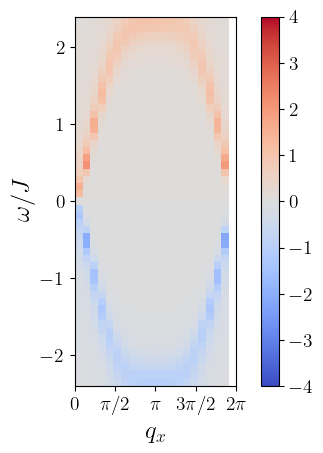

In [254]:
normed = mclr.Normalize(-4.,4.)
plt.imshow(np.transpose(spectra[:,0,:]),origin='lower',extent=[kxs[0],kxs[-1],ws[0]/J,ws[-1]/J],cmap='coolwarm',aspect=3,norm=normed)
plt.ylabel(r'$\omega/J$')
plt.ylim(-4.5*J,4.5*J)
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.colorbar()
#if saveFigs: plt.savefig(figDirectory+"/Magnon_spectrum.pdf",bbox_inches='tight')
plt.show()